<a href="https://colab.research.google.com/github/fralfaro/MAT306/blob/main/docs/labs/lab_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT306 - Laboratorio N°08

**Objetivo**: Aplicar técnicas de **machine learning no supervisado** para explorar, procesar y analizar conjuntos de datos con variables numéricas y categóricas.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


## Clustering


<img src="https://www.svgrepo.com/show/253022/car.svg" width = "300" align="center"/>



El conjunto de datos **`vehiculos_procesado_con_grupos.csv`** recopila información sobre diversas características relevantes de distintos vehículos. El propósito de este ejercicio es **clasificar los vehículos en diferentes categorías**, utilizando como base las variables descritas en la tabla de atributos.

El análisis presenta un desafío adicional debido a la **naturaleza mixta de los datos**: se incluyen tanto variables **numéricas** (ej. dimensiones, consumo, emisiones) como **categóricas** (ej. tipo de tracción, tipo de combustible), lo que requiere aplicar técnicas de preprocesamiento adecuadas antes de entrenar los modelos.

Como primer paso, procederemos a **cargar y explorar el conjunto de datos**, con el fin de familiarizarnos con su estructura y las características que servirán como base para la posterior clasificación.




**Descripción de los Datos:**

| **Nombre de la Columna**   | **Descripción**                                                                                                                                   |
|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------|
| **year**                   | El año en que el vehículo fue fabricado.                                                                                                          |
| **desplazamiento**          | La capacidad volumétrica del motor en litros. Indica la cantidad de aire y combustible que puede desplazar el motor durante una revolución.       |
| **cilindros**               | El número de cilindros que tiene el motor. Los cilindros son las cámaras donde ocurre la combustión interna en los motores de los vehículos.       |
| **co2**                     | Emisiones de dióxido de carbono del vehículo, medido en gramos por kilómetro. Es una medida de las emisiones de gases de efecto invernadero.       |
| **clase_tipo**              | La clase o tipo de vehículo, como vehículos especiales, deportivos, etc.                                                                         |
| **traccion_tipo**           | Tipo de tracción del vehículo, ya sea tracción en dos ruedas, en cuatro ruedas o en todas las ruedas.                                             |
| **transmision_tipo**        | Tipo de transmisión del vehículo, como automática, manual, entre otros.                                                                          |
| **combustible_tipo**        | Tipo de combustible que utiliza el vehículo, como gasolina, diésel, eléctrico, híbrido, etc.                                                     |
| **tamano_motor_tipo**       | Clasificación del tamaño del motor (por ejemplo, pequeño, mediano o grande), que generalmente se basa en la capacidad de desplazamiento.           |
| **consumo_tipo**            | Clasificación del nivel de consumo de combustible del vehículo, indicando si es alto, bajo, o muy alto.                                           |
| **co2_tipo**                | Clasificación de las emisiones de CO2 del vehículo, indicando si es alto, bajo, o muy alto.                                                       |
| **consumo_litros_milla**    | El consumo de combustible del vehículo, medido en litros por milla. Indica la eficiencia del vehículo en términos de consumo de combustible.        |



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans


%matplotlib inline

sns.set_palette("deep", desat=.6)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
# cargar datos
df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT306/main/docs/labs/data/vehiculos_procesado_con_grupos.csv", sep=",")\
       .drop(
            ["fabricante",
             "modelo",
             "transmision",
             "traccion",
             "clase",
             "combustible",
             "consumo"],

          axis=1)

df.head()

,year,desplazamiento,cilindros,co2,clase_tipo,traccion_tipo,transmision_tipo,combustible_tipo,tamano_motor_tipo,consumo_tipo,co2_tipo,consumo_litros_milla
0,1984,2.5,4.0,522.764706,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.222671
1,1984,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
2,1985,2.5,4.0,555.437500,Vehículos Especiales,dos,Automatica,Normal,pequeño,alto,alto,0.236588
3,1985,4.2,6.0,683.615385,Vehículos Especiales,dos,Automatica,Normal,grande,muy alto,muy alto,0.291185
4,1987,3.8,6.0,555.437500,Coches Medianos,dos,Automatica,Premium,grande,alto,alto,0.236588


En este caso, no solo se tienen datos numéricos, sino que también categóricos. Además, tenemos problemas de datos **vacíos (Nan)**. Así que para resolver este problema, seguiremos varios pasos:

### 1.- Normalizar datos

- Cree un conjunto de datos con las variables numéricas, además, para cada dato vacía, rellene con el promedio asociado a esa columna. Finalmente, normalize los datos mediante el procesamiento **MinMaxScaler** de **sklearn**.
- Cree un conjunto de datos con las variables categóricas , además, transforme de variables categoricas a numericas ocupando el comando **get_dummies** de pandas ([referencia](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)). Explique a grande rasgo como se realiza la codificación de variables numéricas a categóricas.

- Junte ambos dataset en uno, llamado **df_procesado**.

In [3]:
# Identificar variables numéricas y categóricas
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()

# Procesar variables numéricas
df_numeric = df[numeric_cols].copy()
df_numeric.fillna(df_numeric.mean(), inplace=True) # Rellenar NaN con la media

scaler = MinMaxScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=numeric_cols)


# Procesar variables categóricas
df_categorical = df[categorical_cols].copy()
df_categorical_encoded = pd.get_dummies(df_categorical, dummy_na=False) # dummy_na=False para no crear columna para NaN

# Juntar ambos datasets
df_procesado = pd.concat([df_numeric_scaled, df_categorical_encoded], axis=1)

print("Dimensiones del dataset procesado:", df_procesado.shape)
df_procesado.head()

Dimensiones del dataset procesado: (36791, 36)


,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,0.000000,0.243590,0.142857,0.398014,0.331027,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
1,0.000000,0.461538,0.285714,0.527672,0.475113,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
2,0.029412,0.243590,0.142857,0.424351,0.360294,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
3,0.029412,0.461538,0.285714,0.527672,0.475113,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,False
4,0.088235,0.410256,0.285714,0.424351,0.360294,False,False,False,True,False,...,True,False,False,False,False,True,False,False,False,False


### 2.- Realizar ajuste mediante kmeans

Una vez depurado el conjunto de datos, es momento de aplicar el algoritmo de **kmeans**.

1. Ajuste el modelo de **kmeans** sobre el conjunto de datos, con un total de **8 clusters**.
2. Asociar a cada individuo el correspondiente cluster y calcular valor de los centroides de cada cluster.
3. Realizar un resumen de las principales cualidades de cada cluster. Para  esto debe calcular (para cluster) las siguientes medidas de resumen:
    * Valor promedio de las variables numérica
    * Moda para las variables numericas

In [7]:
# Ajustar el modelo K-Means con 8 clusters
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10) # n_init='auto' in newer versions of sklearn
kmeans.fit(df_procesado.drop('cluster', axis=1))

# Asociar cada individuo al cluster correspondiente
df_procesado['cluster'] = kmeans.labels_

# Calcular los centroides de cada cluster
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_procesado.columns[:-1])

print("Centroides de los clusters:")
display(centroids)

# Resumen de las principales cualidades de cada cluster
cluster_summary_mean = df_procesado.groupby('cluster')[numeric_cols].mean()
print("\nValor promedio de las variables numéricas por cluster:")
display(cluster_summary_mean)

# Moda para las variables categóricas por cluster (aproximación - la moda no es ideal para datos numéricos continuos)
# Para variables categóricas codificadas, la suma puede interpretarse como frecuencia, pero la moda real sería sobre las columnas originales.
# Sin embargo, basándonos en la instrucción original de "Moda para las variables numericas", calcularemos la moda de las columnas numéricas.
# Nota: Calcular la moda para variables numéricas continuas no es muy informativo. Se podría considerar la mediana o cuantiles.
# Si se refería a las variables categóricas originales, necesitaríamos agrupar por cluster y calcular la moda en esas columnas.
# Asumiré que se refiere a las variables numéricas para seguir la instrucción.

# Calculando la moda para las columnas numéricas dentro de cada cluster
def mode_for_cluster(x):
    modes = {}
    for col in numeric_cols:
        # Use .mode().iloc[0] to get the first mode if multiple exist
        modes[col] = x[col].mode().iloc[0] if not x[col].mode().empty else np.nan
    return pd.Series(modes, index=numeric_cols)


cluster_summary_mode_numeric = df_procesado.groupby('cluster').apply(mode_for_cluster)
print("\nModa de las variables numéricas por cluster:")
display(cluster_summary_mode_numeric)

# Si se quisera la moda de las variables categóricas originales:
# cluster_summary_mode_categorical = df.groupby(df_procesado['cluster'])[categorical_cols].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
# print("\nModa de las variables categóricas originales por cluster:")
# display(cluster_summary_mode_categorical)

Centroides de los clusters:


,year,desplazamiento,cilindros,co2,consumo_litros_milla,clase_tipo_Camionetas,clase_tipo_Coche Familiar,clase_tipo_Coches Grandes,clase_tipo_Coches Medianos,clase_tipo_Coches pequeños,...,consumo_tipo_alto,consumo_tipo_bajo,consumo_tipo_moderado,consumo_tipo_muy alto,consumo_tipo_muy bajo,co2_tipo_alto,co2_tipo_bajo,co2_tipo_moderado,co2_tipo_muy alto,co2_tipo_muy bajo
0,0.427318,0.223790,0.173637,0.304599,0.226412,0.126441,0.097434,0.004835,0.088137,0.517665,...,1.831868e-15,9.776869e-01,9.048318e-15,9.076073e-15,2.231313e-02,4.635181e-15,9.921904e-01,7.809595e-03,4.246603e-15,-1.201816e-14
1,0.569367,0.169607,0.146057,0.240820,0.156357,0.007990,0.117281,0.017606,0.138407,0.629063,...,-1.232348e-14,-1.679212e-14,1.354280e-04,-1.024181e-14,9.998646e-01,-9.103829e-15,1.218852e-03,8.125677e-04,8.160139e-15,9.979686e-01
2,0.407666,0.331397,0.256796,0.354288,0.282121,0.181278,0.084035,0.090474,0.133564,0.184580,...,-7.271961e-15,1.386825e-02,9.808486e-01,7.355228e-15,5.283143e-03,1.155688e-03,-1.712519e-14,9.988443e-01,-6.022960e-15,-1.582068e-15
3,0.476969,0.450984,0.327266,0.410019,0.343261,0.304450,0.017116,0.041506,0.048567,0.151048,...,9.584938e-01,-1.421085e-14,4.065041e-02,8.557980e-04,-6.578071e-15,9.957210e-01,7.494005e-16,6.418485e-04,3.637142e-03,-1.768030e-14
4,0.384236,0.585590,0.430797,0.510289,0.454503,0.259250,0.005599,0.059153,0.059396,0.197420,...,3.115871e-02,-1.321165e-14,1.168452e-02,9.571568e-01,-6.494805e-15,1.703992e-03,7.494005e-16,4.868549e-04,9.978092e-01,-1.662559e-14
5,0.588730,0.362290,0.299545,0.354136,0.282247,0.001505,0.083020,0.086531,0.189616,0.558816,...,5.016303e-04,2.608478e-02,9.731628e-01,1.360023e-14,2.508151e-04,2.357662e-02,7.771561e-16,9.764234e-01,-1.040834e-14,-1.634803e-14
6,0.452443,0.562730,0.405562,0.501887,0.442585,0.435441,0.001318,0.003953,0.010211,0.058300,...,5.764163e-02,-1.032507e-14,5.599473e-03,9.367589e-01,-6.300516e-15,6.883383e-15,7.216450e-16,-9.436896e-15,1.000000e+00,-1.357248e-14
7,0.579550,0.269830,0.210005,0.305067,0.226473,0.025947,0.094316,0.072488,0.192545,0.397446,...,6.177924e-04,9.619028e-01,8.237232e-04,1.523781e-14,3.665568e-02,2.969847e-15,9.684926e-01,2.944811e-02,-1.587619e-14,2.059308e-03



Valor promedio de las variables numéricas por cluster:


,year,desplazamiento,cilindros,co2,consumo_litros_milla
cluster,,,,,
0,0.427318,0.223790,0.173637,0.304599,0.226412
1,0.569367,0.169607,0.146057,0.240820,0.156357
2,0.407666,0.331397,0.256796,0.354288,0.282121
3,0.476969,0.450984,0.327266,0.410019,0.343261
4,0.384236,0.585590,0.430797,0.510289,0.454503
5,0.588730,0.362290,0.299545,0.354136,0.282247
6,0.452443,0.562730,0.405562,0.501887,0.442585
7,0.579550,0.269830,0.210005,0.305067,0.226473



Moda de las variables numéricas por cluster:


/tmp/ipython-input-815603470.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_summary_mode_numeric = df_procesado.groupby('cluster').apply(mode_for_cluster)


,year,desplazamiento,cilindros,co2,consumo_litros_milla
cluster,,,,,
0,0.000000,0.179487,0.142857,0.317749,0.241830
1,0.970588,0.179487,0.142857,0.275108,0.194444
2,0.000000,0.307692,0.285714,0.374603,0.305011
3,0.029412,0.474359,0.285714,0.424351,0.331027
4,0.000000,0.564103,0.428571,0.454199,0.393464
5,0.617647,0.307692,0.285714,0.374603,0.281734
6,0.558824,0.653846,0.428571,0.454199,0.393464
7,0.970588,0.179487,0.142857,0.317749,0.241830


### 3.- Elegir Número de cluster

Estime mediante la **regla del codo**, el número de cluster apropiados para el caso.
Para efectos prácticos, eliga la siguiente secuencia como número de clusters a comparar:

$$[5, 10, 20, 30, 50, 75, 100, 200, 300]$$

Una vez realizado el gráfico, saque sus propias conclusiones del caso.

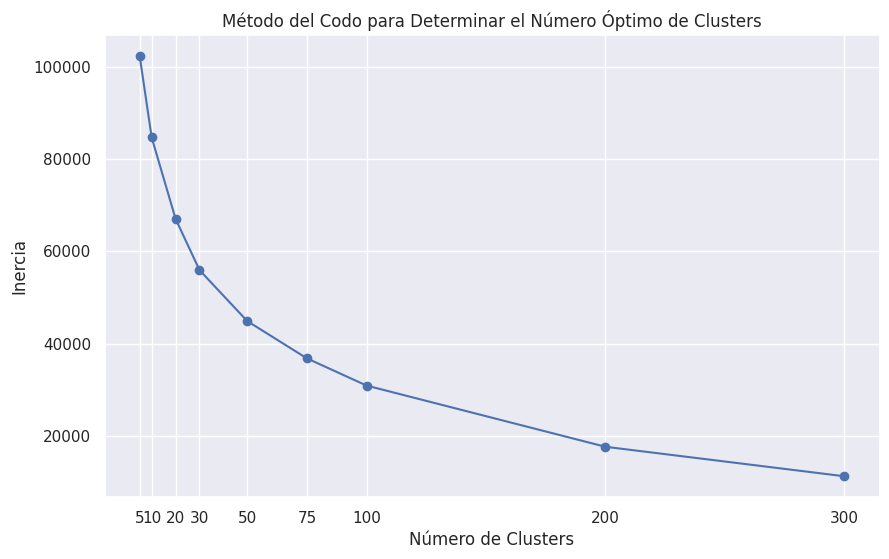

In [8]:
# Definir la secuencia de números de clusters a comparar
n_clusters_list = [5, 10, 20, 30, 50, 75, 100, 200, 300]

# Calcular la inercia para cada número de clusters
inertia = []
for n_clusters in n_clusters_list:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(df_procesado.drop('cluster', axis=1)) # Excluir la columna 'cluster'
    inertia.append(kmeans.inertia_)

# Graficar la inercia vs el número de clusters
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_list, inertia, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo para Determinar el Número Óptimo de Clusters')
plt.xticks(n_clusters_list)
plt.grid(True)
plt.show()

La regla del codo sugiere elegir el número de clusters donde la reducción en la inercia se estabiliza significativamente. En otras palabras, se busca el punto en el gráfico donde la curva de inercia comienza a aplanarse o forma un codo. Esto sucede entre los 30 y 75 clusters. Por lo que elijo 50 clusters como un número ideal, siguiendo la heurística. Esto quiere decir, que si fitteamos con 50 clusters, el modelo detectará aproximadamente unos 50 tipos de autos distintos, y agrupa cada auto en uno de esos grupos.

## Reducción de Dimensionalidad

<img src="https://1000logos.net/wp-content/uploads/2020/11/Wine-Logo-old.png" width = "300" align="center"/>


Para este ejercicio utilizaremos el **Wine Dataset**, un conjunto de datos clásico disponible en la librería **scikit-learn** y en el repositorio de la **UCI Machine Learning**.
Este dataset contiene información de **178 muestras de vino** provenientes de la región italiana de *Piamonte*. Cada vino pertenece a una de **tres variedades de uva** (*clases*), que actúan como etiquetas para el análisis supervisado, pero aquí se usarán solo como referencia en la visualización.

Cada muestra está descrita por **13 variables químicas** obtenidas de un análisis de laboratorio, entre ellas:

* **Alcohol**: porcentaje de alcohol en el vino.
* **Malic acid**: concentración de ácido málico.
* **Ash**: contenido de ceniza.
* **Alcalinity of ash**: alcalinidad de la ceniza.
* **Magnesium**: cantidad de magnesio (mg/L).
* **Total phenols**: concentración total de fenoles.
* **Flavanoids**: tipo de fenoles con propiedades antioxidantes.
* **Nonflavanoid phenols**: fenoles que no son flavonoides.
* **Proanthocyanins**: compuestos relacionados con el color y el sabor.
* **Color intensity**: intensidad del color del vino.
* **Hue**: matiz del color.
* **OD280/OD315 of diluted wines**: relación de absorbancia que mide la calidad del vino.
* **Proline**: concentración de prolina (un aminoácido).

Estas características permiten representar cada vino como un punto en un espacio de **13 dimensiones**.

El objetivo del análisis con este dataset es **reducir la dimensionalidad** para visualizar y explorar patrones en los datos. Para ello aplicaremos:

* **PCA (Principal Component Analysis):** identificar las combinaciones lineales de variables que explican la mayor varianza en el conjunto.
* **t-SNE (t-distributed Stochastic Neighbor Embedding):** mapear las muestras a 2D o 3D, preservando relaciones de vecindad y estructuras no lineales.

La comparación entre ambas técnicas permitirá observar cómo las tres clases de vinos se diferencian en el espacio reducido y discutir la utilidad de la reducción de dimensionalidad en datos con mayor número de variables que en el caso del dataset *Wine*.



In [12]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [13]:
# cargar dataset
dataset = load_wine()

# nombres de las variables
features = dataset.feature_names
target = 'wine_class'

# construir DataFrame
wine = pd.DataFrame(dataset.data, columns=features)
wine[target] = dataset.target

# ver primeras filas
wine.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0




### 1. **Análisis detallado con PCA**

* Calcular la **varianza explicada** por cada componente principal y representar el gráfico de varianza acumulada, identificando cuántos componentes son necesarios para capturar al menos el **90–95% de la información**.
* Construir tablas y gráficos que muestren cómo las observaciones (vinos) se proyectan en las primeras componentes principales.
* Analizar los **loadings** (coeficientes de cada variable en los componentes) e interpretar qué características químicas del vino (alcohol, fenoles, color, etc.) tienen mayor influencia en las nuevas dimensiones.
* Visualizar los datos reducidos a 2D o 3D e interpretar si las **tres variedades de vino** se separan de forma clara en el espacio proyectado.



Varianza explicada por cada componente principal (después de escalar):
Componente 1: 0.3620
Componente 2: 0.1921
Componente 3: 0.1112
Componente 4: 0.0707
Componente 5: 0.0656
Componente 6: 0.0494
Componente 7: 0.0424
Componente 8: 0.0268
Componente 9: 0.0222
Componente 10: 0.0193
Componente 11: 0.0174
Componente 12: 0.0130
Componente 13: 0.0080


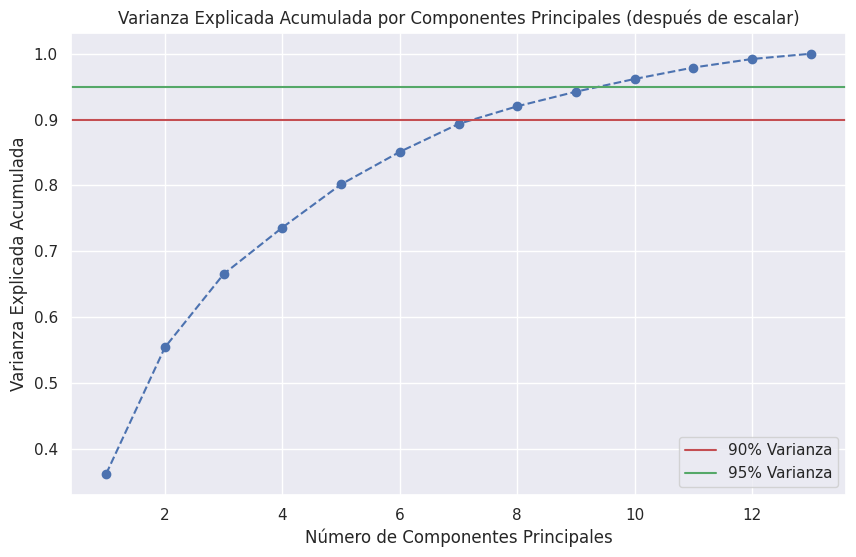


Número de componentes necesarios para capturar al menos el 90% de la varianza: 8
Número de componentes necesarios para capturar al menos el 95% de la varianza: 10

Proyección de las observaciones en las primeras 2 componentes principales (después de escalar):


,PC1,PC2,wine_class
0,3.316751,1.443463,0
1,2.209465,-0.333393,0
2,2.516740,1.031151,0
3,3.757066,2.756372,0
4,1.008908,0.869831,0



Proyección de las observaciones en las primeras 3 componentes principales (después de escalar):


,PC1,PC2,PC3,wine_class
0,3.316751,1.443463,-0.165739,0
1,2.209465,-0.333393,-2.026457,0
2,2.516740,1.031151,0.982819,0
3,3.757066,2.756372,-0.176192,0
4,1.008908,0.869831,2.026688,0


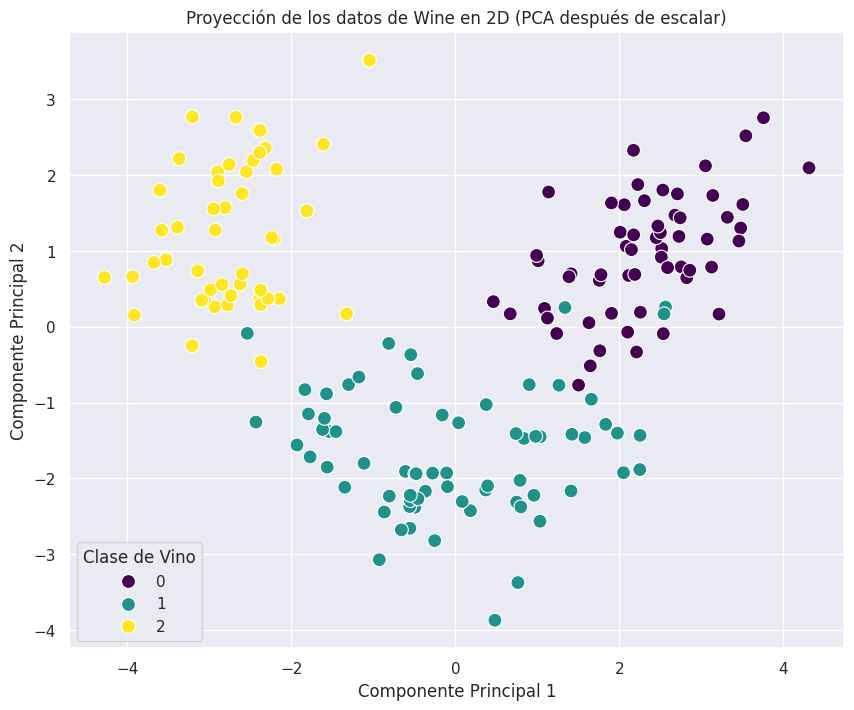

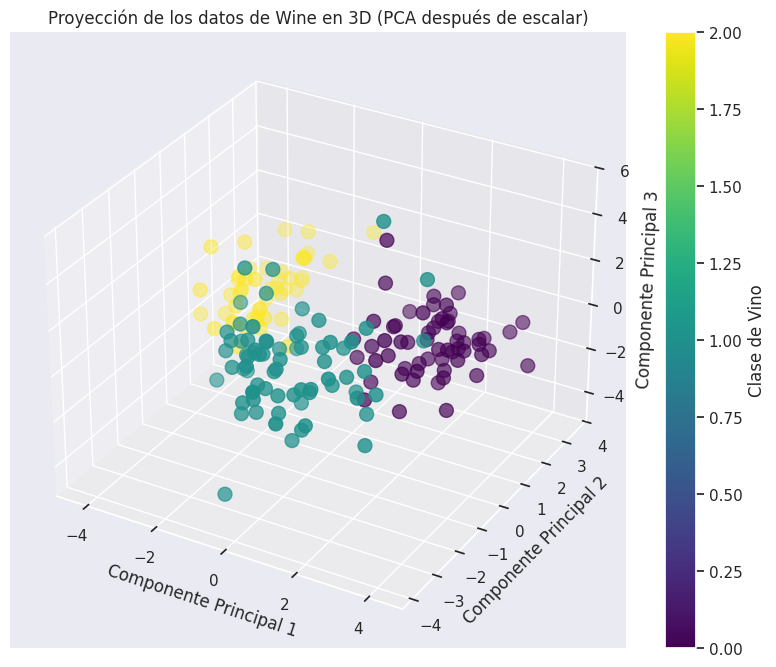


Loadings (coeficientes de las variables en las componentes principales después de escalar):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
alcohol,0.144329,0.483652,-0.207383,-0.017856,-0.265664,0.213539,-0.056396,0.396139,-0.508619,0.211605,-0.225917,-0.266286,0.014970
malic_acid,-0.245188,0.224931,0.089013,0.536890,0.035214,0.536814,0.420524,0.065827,0.075283,-0.309080,0.076486,0.121696,0.025964
ash,-0.002051,0.316069,0.626224,-0.214176,-0.143025,0.154475,-0.149171,-0.170260,0.307694,-0.027125,-0.498691,-0.049622,-0.141218
alcalinity_of_ash,-0.239320,-0.010591,0.612080,0.060859,0.066103,-0.100825,-0.286969,0.427970,-0.200449,0.052799,0.479314,-0.055743,0.091683
magnesium,0.141992,0.299634,0.130757,-0.351797,0.727049,0.038144,0.322883,-0.156361,-0.271403,0.067870,0.071289,0.062220,0.056774
total_phenols,0.394661,0.065040,0.146179,0.198068,-0.149318,-0.084122,-0.027925,-0.405934,-0.286035,-0.320131,0.304341,-0.303882,-0.463908
flavanoids,0.422934,-0.003360,0.150682,0.152295,-0.109026,-0.018920,-0.060685,-0.187245,-0.049578,-0.163151,-0.025694,-0.042899,0.832257
nonflavanoid_phenols,-0.298533,0.028779,0.170368,-0.203301,-0.500703,-0.258594,0.595447,-0.233285,-0.195501,0.215535,0.116896,0.042352,0.114040
proanthocyanins,0.313429,0.039302,0.149454,0.399057,0.136860,-0.533795,0.372139,0.368227,0.209145,0.134184,-0.237363,-0.095553,-0.116917
color_intensity,-0.088617,0.529996,-0.137306,0.065926,-0.076437,-0.418644,-0.227712,-0.033797,-0.056218,-0.290775,0.031839,0.604222,-0.011993



Variables con mayor influencia en la Componente Principal 1 (después de escalar):
flavanoids                      0.422934
total_phenols                   0.394661
od280/od315_of_diluted_wines    0.376167
proanthocyanins                 0.313429
hue                             0.296715
proline                         0.286752
alcohol                         0.144329
magnesium                       0.141992
ash                            -0.002051
color_intensity                -0.088617
alcalinity_of_ash              -0.239320
malic_acid                     -0.245188
nonflavanoid_phenols           -0.298533
Name: PC1, dtype: float64

Variables con mayor influencia en la Componente Principal 2 (después de escalar):
color_intensity                 0.529996
alcohol                         0.483652
proline                         0.364903
ash                             0.316069
magnesium                       0.299634
malic_acid                      0.224931
total_phenols                

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D # Import for 3D plotting
from sklearn.preprocessing import StandardScaler # Import StandardScaler

# Separar características y objetivo
X = wine.drop(target, axis=1)
y = wine[target]

# Escalar las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Calcular la varianza explicada por cada componente principal
pca = PCA()
pca.fit(X_scaled) # Aplicar PCA a los datos escalados

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

print("Varianza explicada por cada componente principal (después de escalar):")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Componente {i+1}: {ratio:.4f}")

# Graficar la varianza acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada por Componentes Principales (después de escalar)')
plt.grid(True)
plt.axhline(y=0.90, color='r', linestyle='-', label='90% Varianza')
plt.axhline(y=0.95, color='g', linestyle='-', label='95% Varianza')
plt.legend()
plt.show()

# Identificar cuántos componentes son necesarios para capturar al menos el 90-95% de la información
n_components_90 = np.argmax(cumulative_explained_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1

print(f"\nNúmero de componentes necesarios para capturar al menos el 90% de la varianza: {n_components_90}")
print(f"Número de componentes necesarios para capturar al menos el 95% de la varianza: {n_components_95}")

# 2. Construir tablas y gráficos que muestren cómo las observaciones se proyectan en las primeras componentes principales.
# Reducir a 2 y 3 dimensiones para visualización
pca_2d = PCA(n_components=2)
wine_pca_2d = pca_2d.fit_transform(X_scaled) # Aplicar PCA a los datos escalados
wine_pca_2d_df = pd.DataFrame(wine_pca_2d, columns=['PC1', 'PC2'])
wine_pca_2d_df['wine_class'] = y # Usar la variable objetivo separada

pca_3d = PCA(n_components=3)
wine_pca_3d = pca_3d.fit_transform(X_scaled) # Aplicar PCA a los datos escalados
wine_pca_3d_df = pd.DataFrame(wine_pca_3d, columns=['PC1', 'PC2', 'PC3'])
wine_pca_3d_df['wine_class'] = y # Usar la variable objetivo separada


print("\nProyección de las observaciones en las primeras 2 componentes principales (después de escalar):")
display(wine_pca_2d_df.head())

print("\nProyección de las observaciones en las primeras 3 componentes principales (después de escalar):")
display(wine_pca_3d_df.head())


# Visualizar los datos reducidos a 2D
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='PC1', y='PC2', hue='wine_class', data=wine_pca_2d_df, palette='viridis', s=100)
plt.title('Proyección de los datos de Wine en 2D (PCA después de escalar)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Clase de Vino')
plt.grid(True)
plt.show()

# Visualizar los datos reducidos a 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(wine_pca_3d_df['PC1'], wine_pca_3d_df['PC2'], wine_pca_3d_df['PC3'], c=wine_pca_3d_df['wine_class'], cmap='viridis', s=100)
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')
ax.set_title('Proyección de los datos de Wine en 3D (PCA después de escalar)')
plt.colorbar(scatter, label='Clase de Vino')
plt.show()


# 3. Analizar los loadings
print("\nLoadings (coeficientes de las variables en las componentes principales después de escalar):")
loadings_df = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=features)
display(loadings_df)

# Interpretar los loadings (ejemplo para PC1 y PC2)
print("\nVariables con mayor influencia en la Componente Principal 1 (después de escalar):")
print(loadings_df['PC1'].sort_values(ascending=False))

print("\nVariables con mayor influencia en la Componente Principal 2 (después de escalar):")
print(loadings_df['PC2'].sort_values(ascending=False))

print("\nVariables con mayor influencia en la Componente Principal 3 (después de escalar):")
print(loadings_df['PC3'].sort_values(ascending=False))

print("\nVariables con mayor influencia en la Componente Principal 4 (después de escalar):")
print(loadings_df['PC4'].sort_values(ascending=False))

Se ve claramente, incluso en 2D, que las tres variedades de vino quedan claramente clusterizadas, aunque hay una pequeña ambiguedad al mezclar la variedad 1 con las variedad 0 y 2, pero es ínfimo.



### 2. **Análisis detallado con t-SNE**

* Aplicar **t-SNE** para reducir los datos a 2 dimensiones, probando diferentes configuraciones de hiperparámetros como *perplexity* y *learning rate*.
* Comparar las distintas visualizaciones obtenidas y discutir cómo los hiperparámetros afectan la estructura de los clústeres.
* Analizar si las **tres clases de vinos** forman agrupaciones definidas y si t-SNE logra capturar relaciones no lineales que PCA no refleja.



/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


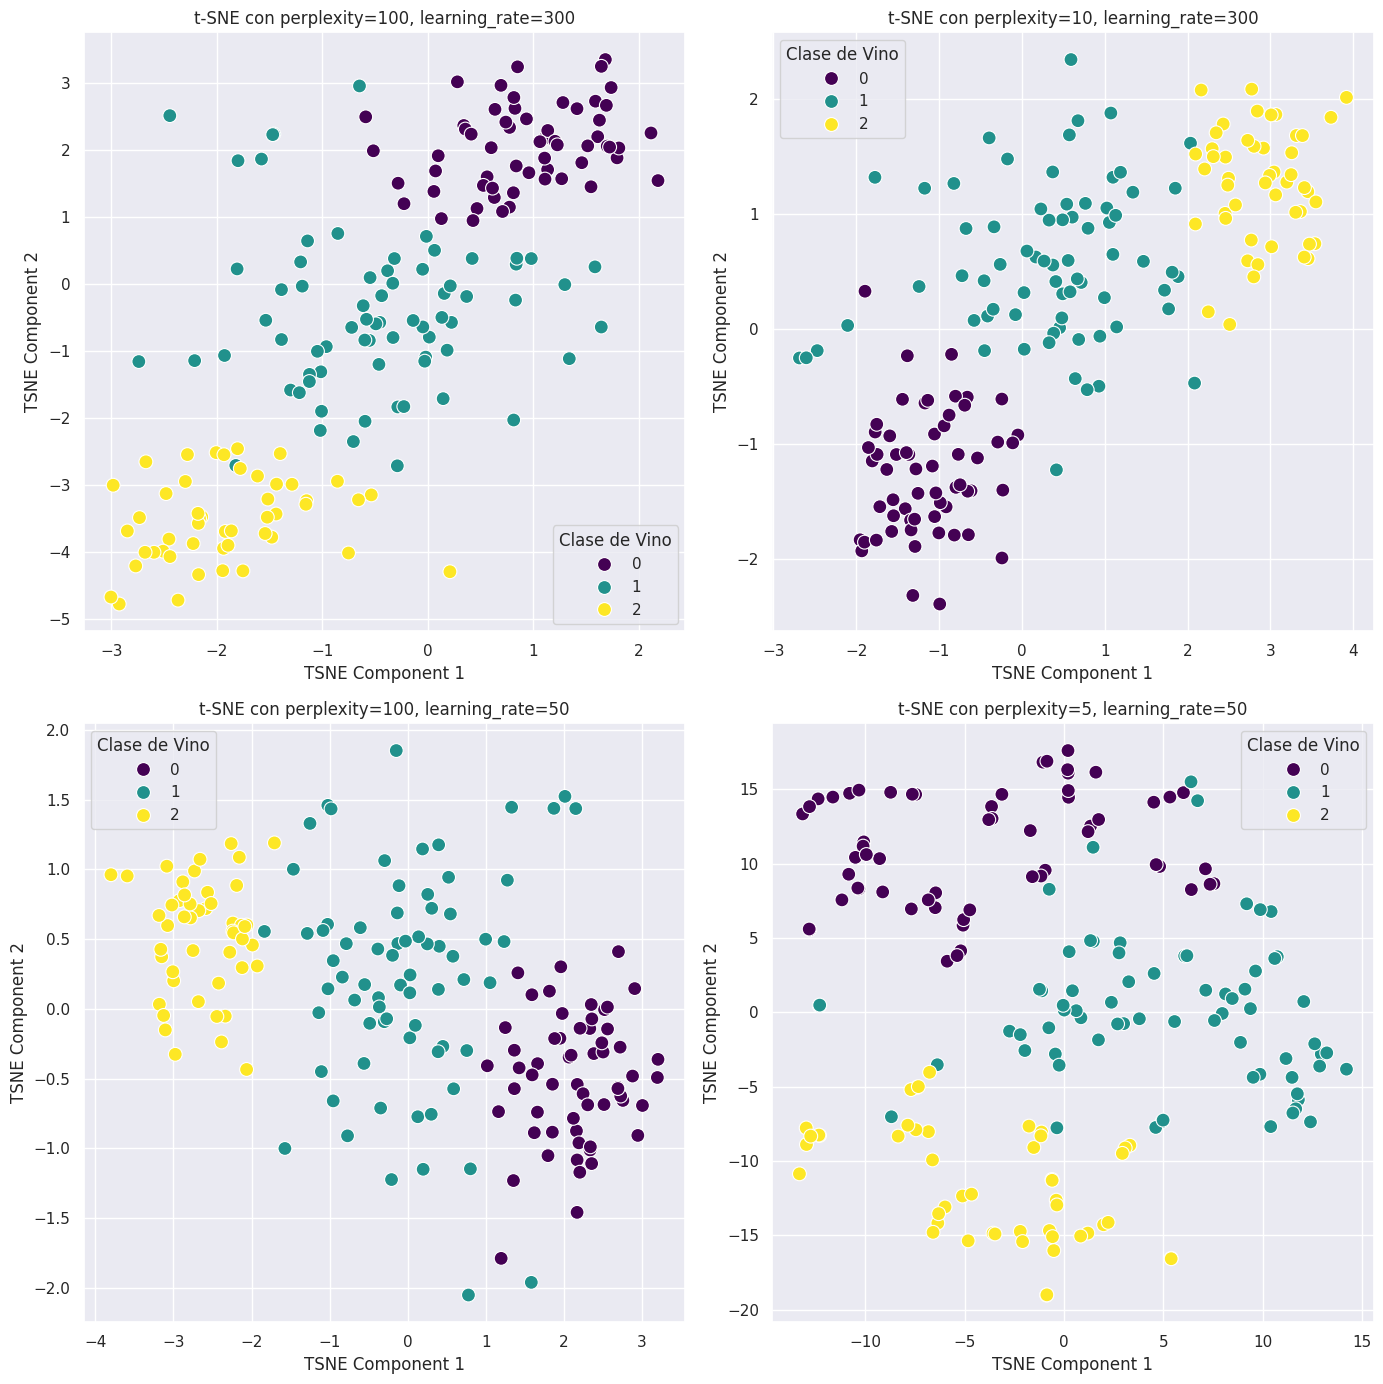

In [45]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Asegúrate de que 'wine' y 'target' estén definidos (ejecuta las celdas anteriores si es necesario)
if 'wine' not in locals() or 'target' not in locals():
    print("Por favor, ejecuta las celdas anteriores para cargar el dataset Wine.")
else:
    # Aplicar t-SNE con diferentes configuraciones de hiperparámetros

    # Configuración 1: Valores por defecto (o comunes)
    tsne_1 = TSNE(n_components=2, random_state=42, perplexity=100, learning_rate=300, n_iter=300)
    wine_tsne_1 = tsne_1.fit_transform(X_scaled)
    wine_tsne_1_df = pd.DataFrame(wine_tsne_1, columns=['TSNE1', 'TSNE2'])
    wine_tsne_1_df['wine_class'] = wine[target]

    # Configuración 2: Modificando perplexity y learning_rate
    tsne_2 = TSNE(n_components=2, random_state=42, perplexity=10, learning_rate=300, n_iter=300)
    wine_tsne_2 = tsne_2.fit_transform(X_scaled)
    wine_tsne_2_df = pd.DataFrame(wine_tsne_2, columns=['TSNE1', 'TSNE2'])
    wine_tsne_2_df['wine_class'] = wine[target]

    # Configuración 3: Modificando perplexity y learning_rate
    tsne_3 = TSNE(n_components=2, random_state=42, perplexity=100, learning_rate=50, n_iter=300)
    wine_tsne_3 = tsne_3.fit_transform(X_scaled)
    wine_tsne_3_df = pd.DataFrame(wine_tsne_3, columns=['TSNE1', 'TSNE2'])
    wine_tsne_3_df['wine_class'] = wine[target]

    # Configuración 4: Modificando perplexity y learning_rate
    tsne_4 = TSNE(n_components=2, random_state=42, perplexity=5, learning_rate=50, n_iter=300)
    wine_tsne_4 = tsne_4.fit_transform(X_scaled)
    wine_tsne_4_df = pd.DataFrame(wine_tsne_4, columns=['TSNE1', 'TSNE2'])
    wine_tsne_4_df['wine_class'] = wine[target]

    # Visualizar los resultados
    plt.figure(figsize=(14, 14))

    plt.subplot(2, 2, 1)
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='wine_class', data=wine_tsne_1_df, palette='viridis', s=100)
    plt.title('t-SNE con perplexity=100, learning_rate=300')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Clase de Vino')
    plt.grid(True)

    plt.subplot(2, 2, 2)
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='wine_class', data=wine_tsne_2_df, palette='viridis', s=100)
    plt.title('t-SNE con perplexity=10, learning_rate=300')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Clase de Vino')
    plt.grid(True)

    plt.subplot(2, 2, 3)
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='wine_class', data=wine_tsne_3_df, palette='viridis', s=100)
    plt.title('t-SNE con perplexity=100, learning_rate=50')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Clase de Vino')
    plt.grid(True)

    plt.subplot(2, 2, 4)
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='wine_class', data=wine_tsne_4_df, palette='viridis', s=100)
    plt.title('t-SNE con perplexity=5, learning_rate=50')
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.legend(title='Clase de Vino')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Perplexity: indica cuántos vecinos “importantes” considera cada punto. Bajo → enfoca en vecinos cercanos; alto → captura estructura más global.

Learning rate: tamaño de paso en la optimización. Bajo → puntos se amontonan; alto → se dispersan demasiado. Afecta estabilidad y forma de los clusters.

No sé si logre identificar relaciones no-lineales que PCA no refleja, pero sí es claro que ahora los cluster quedan mucho más separados y mejor definidos, en el caso de perplexity=5, learning_Rate=50 obtenemos el mejro resultado en este sentido.

Los 4 gráficos son bastante diferentes, hay que tener cuidado con atribuir características visuales al resultado de los datasets y no al mero cambio de hiperparámetros.



### 3. **Comparación entre PCA y t-SNE**

* Contrastar las visualizaciones y discutir las **ventajas y limitaciones** de cada técnica:

  * PCA como método **lineal** para interpretar varianza y relaciones globales.
  * t-SNE como método **no lineal** que preserva relaciones locales y vecindades.
* Evaluar en qué escenarios prácticos sería más recomendable usar PCA (interpretabilidad, reducción previa para modelos) o t-SNE (exploración y visualización de clústeres).
* Reflexionar sobre la **importancia de la reducción de dimensionalidad** en datasets de alta dimensión como Wine, destacando su utilidad para:

  * Visualizar patrones ocultos en los datos.
  * Reducir complejidad y ruido antes de aplicar algoritmos de aprendizaje automático.
  * Facilitar la interpretación y comunicación de resultados.



### Comparación y Reflexión Final

Las visualizaciones hechas por t-SNE separaron mejor los clusters y permiten alta flexibilidad a través de los hiperparámetros, además de que permiten detectar relaciones reales pero no-lineales entre los clusters.

**Ventajas y Limitaciones:**

*   **PCA:**
    *   **Ventajas:** Rápido, determinista, interpretable en términos de varianza explicada, útil para reducción de ruido y preprocesamiento.
    *   **Limitaciones:** Lineal (no captura estructuras no lineales), la visualización puede no separar clústeres no lineales.
*   **t-SNE:**
    *   **Ventajas:** Excelente para visualización de clústeres, captura relaciones no lineales, efectivo para datos complejos.
    *   **Limitaciones:** Computacionalmente costoso para datasets grandes, no determinista (resultados pueden variar ligeramente con diferentes ejecuciones), interpretación de distancias en el espacio reducido no es trivial, sensible a hiperparámetros.

**PCA**: busca las direcciones de mayor varianza global. Cada componente principal intenta capturar la mayor parte de la dispersión total del dataset. No distingue entre vecinos cercanos o lejanos; optimiza para reconstruir la estructura global.

**t-SNE**: construye probabilidades de similitud solo entre vecinos cercanos en el espacio original y ajusta el embedding para preservar esas relaciones. La pérdida penaliza que vecinos cercanos se separen mucho, mientras que distancias entre puntos lejanos no se optimizan tanto.

Por eso t-SNE refleja la estructura local, y PCA refleja la estructura global.

**Importancia de la Reducción de Dimensionalidad:**

Para datasets de alta dimensión como el de Wine (13 variables), la reducción de dimensionalidad es crucial porque:

*   **Facilita la Visualización:** Permite representar los datos en 2D o 3D, haciendo posible la identificación visual de patrones, clústeres y valores atípicos que serían imposibles de ver en el espacio original de alta dimensión.
*   **Reduce la Complejidad y el Ruido:** Al capturar la mayor parte de la varianza en un número menor de dimensiones, se puede eliminar parte del ruido presente en las dimensiones menos importantes, mejorando el rendimiento de algoritmos posteriores.
*   **Mejora el Rendimiento de Algoritmos:** Menos dimensiones implican menos características para que los algoritmos de aprendizaje automático procesen, lo que puede acelerar el entrenamiento y, en algunos casos, mejorar la precisión al mitigar la maldición de la dimensionalidad.
*   **Ayuda a la Interpretación y Comunicación:** Un espacio de menor dimensión es más fácil de entender y explicar a otros, lo que facilita la comunicación de los hallazgos del análisis de datos.

En resumen, tanto PCA como t-SNE son herramientas valiosas para la reducción de dimensionalidad, cada una con sus fortalezas. PCA es útil para una comprensión global y lineal, mientras que t-SNE sobresale en la visualización de estructuras de clústeres complejas y no lineales. La elección entre ellas (o el uso de ambas) depende del objetivo específico del análisis.

PCA es además un método teórica con una clara y sólida justificación teórica para hacer reducción de dimensionalidad, no solo visualización de clusters.